### **Importing Libraries**

In [37]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from networkx.algorithms.community.centrality import girvan_newman
from operator import mul
import networkx as nx
import os
import sys
import community.community_louvain as community
import matplotlib.image as mpimg
import matplotlib.colors as mpcolors
import matplotlib.cm as mpcm
from itertools import permutations
from itertools import combinations
from collections import defaultdict

### **Loading DataSet**

In [38]:
data_url = "./Dataset/Cit-HepPh.txt"
df_data_1 = pd.read_csv(data_url, sep='\t', skiprows=4, names=['FromNodeId', 'ToNodeId'], dtype={'FromNodeId': int, 'ToNodeId': int})

### **Loading Time of Release**

In [39]:
data_url = "./Dataset/cit-HepPh-dates.txt"
df_data_2 = pd.read_csv(data_url, sep='\t', skiprows=1, names=['NodeId', 'Date'], dtype={'NodeId': str, 'Date': str})
df_data_2['Date'] = pd.to_datetime(df_data_2['Date'])
df_data_2 = df_data_2[~df_data_2['NodeId'].str.startswith('11')]
df_data_2['NodeId'] = df_data_2['NodeId'].astype(str).str.lstrip('0')
df_data_2['NodeId'] = df_data_2['NodeId'].astype(int)
df_data_2 = df_data_2[df_data_2['Date'].dt.year <= 1992]
i = 0
unnodes = df_data_2['NodeId']
for nodes in unnodes:
    i += 1
print(i)


755


### **Merging Both DataSet**

In [40]:
df_merged = pd.merge(df_data_1, df_data_2, how='inner', left_on='FromNodeId', right_on='NodeId')
df_merged['Date'] = pd.to_datetime(df_merged['Date'])
# Filter out rows where 'ToNodeId' is not present in 'NodeId' column of df_data_2
df_merged = df_merged[df_merged['ToNodeId'].isin(df_data_2['NodeId'])]
unnodes = df_merged['FromNodeId'].unique()
i = 0
for nodes in unnodes:
    i += 1
print(i)

105


### **Creation of Graph**

In [41]:

# Construct the directed graph
G_lat = nx.from_pandas_edgelist(df_merged, 'FromNodeId', 'ToNodeId', create_using=nx.DiGraph())

print("Number of nodes:", len(G_lat.nodes()))
print("Number of edges:", len(G_lat.edges()))
print(nx.density(G_lat))



Number of nodes: 173
Number of edges: 152
0.005108213469552359


### **Label Propagation Algorithm**

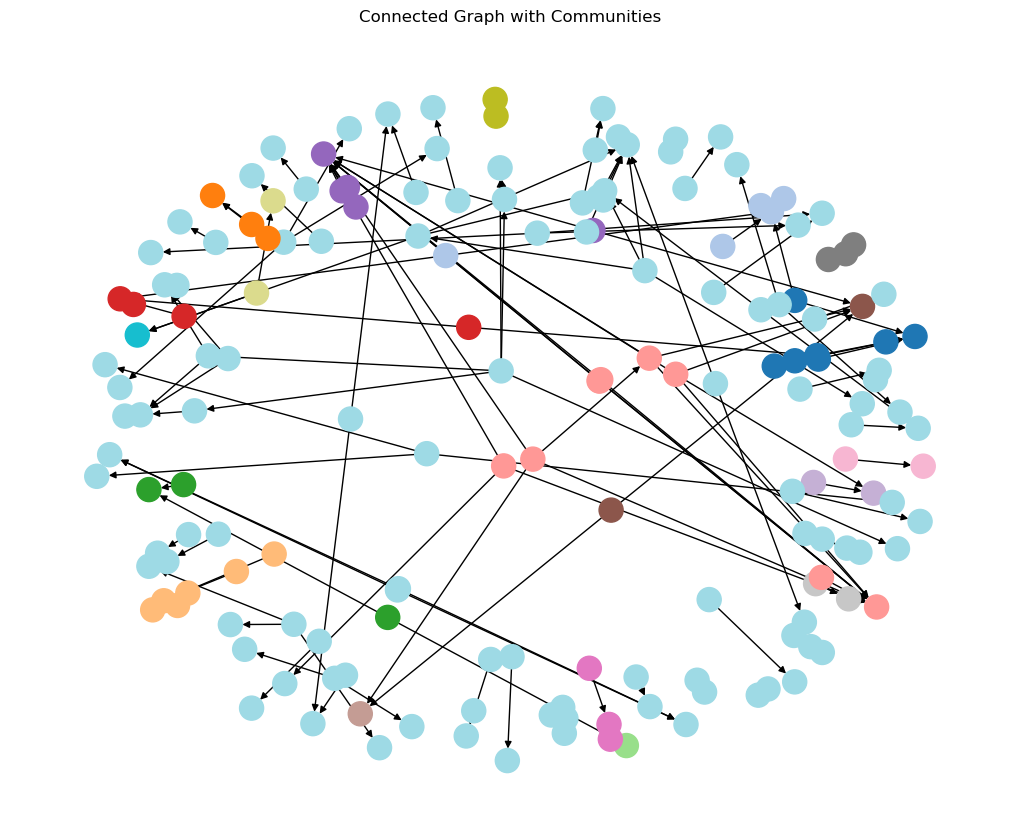

In [42]:
from collections import defaultdict

def label_propagation_directed(G):
    # Initialize labels for each node
    labels = {node: node for node in G.nodes()}
    
    while True:
        # Create a copy of current labels to check for convergence
        old_labels = labels.copy()
        
        # Iterate over each node in the graph
        for node in G.nodes():
            # Get the labels of the neighbors of the current node
            neighbor_labels = [labels[neighbor] for neighbor in G.successors(node)]
            
            if neighbor_labels:  # Check if there are any outgoing edges from the current node
                # Count the occurrences of each label
                label_counts = defaultdict(int)
                for label in neighbor_labels:
                    label_counts[label] += 1
                
                # Get the label with the highest count
                max_label = max(label_counts, key=label_counts.get)
                
                # Update the label of the current node
                labels[node] = max_label
        
        # Check for convergence
        if old_labels == labels:
            break
    
    # Construct communities based on labels
    communities = defaultdict(list)
    for node, label in labels.items():
        communities[label].append(node)
    
    return communities




communities = label_propagation_directed(G_lat)
# print("Communities identified by Label Propagation:")
# for label, nodes in communities.items():
#     print("Community {}: {}".format(label, nodes))

# Assign community information as node attributes
# for label, nodes in communities.items():
#     for node in nodes:
#         G_lat.nodes[node]['community'] = label

# # Export the graph to GraphML format
# nx.write_graphml(G_lat, "graph_with_communities.graphml")

for label, nodes in communities.items():
    for node in nodes:
        G_lat.nodes[node]['community'] = label

# Create a color map for communities
community_colors = {}
for i, label in enumerate(communities):
    community_colors[label] = plt.cm.tab20(i)  # Adjust colormap as needed

# Extract community information as a node attribute
node_colors = [community_colors[G_lat.nodes[node]['community']] for node in G_lat.nodes()]

# Plot the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_lat)  # Change layout if needed
nx.draw(G_lat, pos, node_color=node_colors, with_labels=False)
plt.title('Connected Graph with Communities')
plt.show()
# plt.savefig("Label_Prop_Gr.png")
